In [1]:
import torch
import torchaudio
import cv2
import seaborn as sns
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подготовка данных

In [2]:
# Просмотр данных

flowers_dir = r"data/flowers"
flower_dataset = r'dataset_flower'

labels = os.listdir(flowers_dir)

for label_name in labels:
    print(f'{label_name=}')
    label_object_counter = len(os.listdir(flowers_dir+f"/{label_name}"))
    print(f'Количество обьектов:{label_object_counter }')
    print('----')
    
'''Так как наша задача классифицировать цветок, то у нас отсутствует смещение априорных значения классов'''

label_name='daisy'
Количество обьектов:764
----
label_name='dandelion'
Количество обьектов:1052
----
label_name='rose'
Количество обьектов:784
----
label_name='sunflower'
Количество обьектов:733
----
label_name='tulip'
Количество обьектов:984
----


'Так как наша задача классифицировать цветок, то у нас отсутствует смещение априорных значения классов'

In [3]:
'''Создание и заполнение сета данных'''
def create_dataset(path:str=None, 
                   input_folder_path:str=None,
                   dataset_name:str=None, 
                   add_labels:bool=False,
                   labels:list=None):
    
        
    dataset_path = path+dataset_name
    train_dir_path = path+dataset_name+'/train'
    test_dir_path = path+dataset_name+'/test'
    
    test_size = 0.2
    
    if add_labels == True:
        
        for label in labels:
            
            if (not os.path.isdir(train_dir_path+f'/{label}')) and (not os.path.isdir(train_dir_path+f'/{label}')):
                
                train_label_path = train_dir_path+f'/{label}' # Место для сохранения тренировочной выборки
                test_label_path= test_dir_path+f'/{label}'    # Место для сохранения тестовой выборки
                label_path = input_folder_path + f'/{label}'  # Место откуда извлекать изображения с меткой
                
                os.makedirs(train_label_path)
                os.makedirs(test_label_path)

                # извлекаем и дробим изображения метки на выборки изображения
                images = [f for f in os.listdir(label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

                # Сохраняем тренировочные и тестовые выборки в dataset под определенной меткой
                for image in train_images:
                    shutil.copy(os.path.join(label_path, image), os.path.join(train_label_path, image))
                    
                for image in test_images:
                    shutil.copy(os.path.join(label_path, image), os.path.join(test_label_path, image))

                print(f'{label} успешно создана')
                print(f'Путь в train:\n{train_label_path}')
                print(f'Путь в test:\n{test_label_path}\n----')
                
                
            else:
                print('Папка уже есть')
                print(f'Путь до структуры:\n{dataset_path}\n')
                

In [4]:
create_dataset(path=r'data/', 
               input_folder_path=r'data\flowers',
               dataset_name='flowers_dataset', 
               add_labels=True, 
               labels=labels)

daisy успешно создана
Путь в train:
data/flowers_dataset/train/daisy
Путь в test:
data/flowers_dataset/test/daisy
----
dandelion успешно создана
Путь в train:
data/flowers_dataset/train/dandelion
Путь в test:
data/flowers_dataset/test/dandelion
----
rose успешно создана
Путь в train:
data/flowers_dataset/train/rose
Путь в test:
data/flowers_dataset/test/rose
----
sunflower успешно создана
Путь в train:
data/flowers_dataset/train/sunflower
Путь в test:
data/flowers_dataset/test/sunflower
----
tulip успешно создана
Путь в train:
data/flowers_dataset/train/tulip
Путь в test:
data/flowers_dataset/test/tulip
----


In [5]:
# Указываем пути к train и test
train_dir = r'data\flowers_dataset\train'
test_dir = r'data\flowers_dataset\test'

In [7]:
# Преобразования для изображений
'''transforms.Normalize был установлен согласно нормализации на наборе данных ImageNet'''
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])  

In [8]:
# Загружаем сет данных в понятный для pytorch формат
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [9]:
# Создаем Dataloader, что бы итерировать датасет партиями по 32 элемента
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # включим перемешивание данных при обучении модели
test_loader = DataLoader(test_dataset, batch_size=32) 

In [10]:
print('Метки:', train_dataset.classes)

Метки: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# Обучение

Будет использоваться resnet18 архитектура, так как для решения данной задачи этого более чем достаточно, берем модель с весами

In [11]:
model = models.resnet18(pretrained=True)
label_counter = len(train_dataset.classes)

d:\A_projects\Test_Task\Flower_Recognizer\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\A_projects\Test_Task\Flower_Recognizer\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Изменяем ласт слой под наш(подготавливаем под наши классы)
model.fc = torch.nn.Linear(model.fc.in_features, label_counter)

In [13]:
# Выбираем устройство на котором будет обучаться модел, в моём случае это CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = model.to(device=device)

In [15]:
# Выбираем оптимизатор и функцию потерь
''' 
Оптимизатор выбирается Adam, просто потому что он универсален
Функция потерь CrossEntropyLoss была выбрана, так как данная задача много классовой классификации
'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_func = torch.nn.CrossEntropyLoss()

In [16]:
# Обучение модели
model_path = r'app\weight\resnet18_classifier.pth'

epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # чистим градиенты всех оптимизированных параметров
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"||Epoch:{epoch+1}::{epochs}|| Loss:{total_loss/len(train_loader):.4f}")
        
        

||Epoch:1::5|| Loss:0.0168
||Epoch:1::5|| Loss:0.0315
||Epoch:1::5|| Loss:0.0451
||Epoch:1::5|| Loss:0.0562
||Epoch:1::5|| Loss:0.0653
||Epoch:1::5|| Loss:0.0737
||Epoch:1::5|| Loss:0.0827
||Epoch:1::5|| Loss:0.0886
||Epoch:1::5|| Loss:0.0951
||Epoch:1::5|| Loss:0.1032
||Epoch:1::5|| Loss:0.1093
||Epoch:1::5|| Loss:0.1166
||Epoch:1::5|| Loss:0.1227
||Epoch:1::5|| Loss:0.1280
||Epoch:1::5|| Loss:0.1314
||Epoch:1::5|| Loss:0.1356
||Epoch:1::5|| Loss:0.1403
||Epoch:1::5|| Loss:0.1451
||Epoch:1::5|| Loss:0.1486
||Epoch:1::5|| Loss:0.1544
||Epoch:1::5|| Loss:0.1571
||Epoch:1::5|| Loss:0.1611
||Epoch:1::5|| Loss:0.1664
||Epoch:1::5|| Loss:0.1695
||Epoch:1::5|| Loss:0.1724
||Epoch:1::5|| Loss:0.1763
||Epoch:1::5|| Loss:0.1786
||Epoch:1::5|| Loss:0.1834
||Epoch:1::5|| Loss:0.1876
||Epoch:1::5|| Loss:0.1911
||Epoch:1::5|| Loss:0.1946
||Epoch:1::5|| Loss:0.1983
||Epoch:1::5|| Loss:0.2007
||Epoch:1::5|| Loss:0.2051
||Epoch:1::5|| Loss:0.2090
||Epoch:1::5|| Loss:0.2135
||Epoch:1::5|| Loss:0.2158
|

In [17]:
# Сохранение модели
torch.save(model.state_dict(), model_path)
print(f"Модель сохранена в {model_path}")

Модель сохранена в app\weight\resnet18_classifier.pth


In [18]:
# Тестовая загрузка модели
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Тестирование 

In [23]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
accuracy = np.mean(np.array(y_true) == np.array(y_pred))

print(f"Точность на тестовых данных:{accuracy*100:.2f}%")

Точность на тестовых данных:93.06%


Посмотрим матрицу ошибок

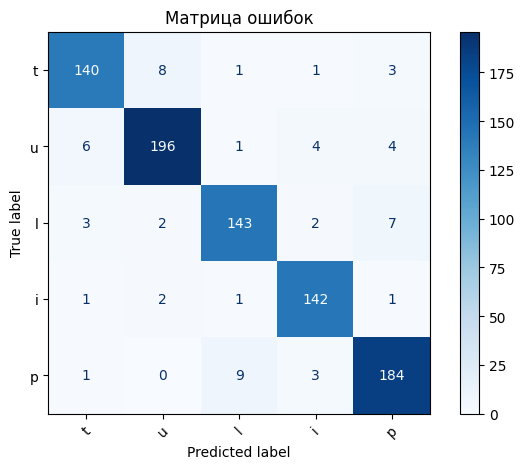

In [27]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Матрица ошибок")
plt.tight_layout()
plt.show()
    